In [23]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
# import pca
from sklearn.decomposition import PCA, FactorAnalysis

# Read in the data
data = pd.read_stata('Cecilia/Eurobarometer_91_5.dta', convert_categoricals=False)
q_selection = ['qf1', 'qf2', 'qa10_1', 'qa10_2', 'qa10_3', 'qa10_6', 'qd1a_3', 'qd2_1', 'qd2_2','qg1']
data_selection = data[q_selection]
for q in ['qf1','qf2']:
    mask = data_selection[q]==2
    data_selection.loc[data_selection[q]==3, q] = 2
    data_selection.loc[mask, q] = 3
    data_selection.loc[data_selection[q]>3, q] = np.nan

data_selection.loc[data_selection['qg1']==2, 'qg1'] = 0

for q in ['qa10_1','qa10_2','qa10_3','qa10_6','qd1a_3','qd2_1','qd2_2']:
    data_selection.loc[data_selection['qg1'].isna(), q] = np.nan
    data_selection.loc[data_selection[q]>4, q] = np.nan

data_selection = data_selection.rename(columns={'qf1':'MS1','qf2':'MS2','qa10_1':'IM1','qa10_2':'IM2','qa10_3':'IM3','qa10_6':'IM4','qd2_1':'ID1','qd2_2':'ID2','qd1a_3':'ID3','qg1':'Wahl'})

In [14]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

data_selection = data_selection[['Wahl', 'ID3', 'ID2', 'ID1', 'IM4', 'IM3', 'IM2', 'IM1', 'MS2', 'MS1']]
# Create trace for correlation matrix
trace1 = go.Heatmap(z=data_selection.corr(), x=data_selection.columns, y=data_selection.columns, coloraxis='coloraxis', text=data_selection.corr().round(2),texttemplate="%{text}")

# Create trace for covariance matrix
trace2 = go.Heatmap(z=data_selection.cov(), x=data_selection.columns, y=data_selection.columns, coloraxis='coloraxis', text=data_selection.cov().round(2),texttemplate="%{text}")

# Create subplot figure
fig = make_subplots(rows=1, cols=2, subplot_titles=('Korrelationsmatrix', 'Kovarianzmatrix'))

# Add traces to subplot figure
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)

# Update subplot layout
fig.update_layout(
    coloraxis = {'colorscale':'RdBu'},
    yaxis = dict(scaleanchor = 'x'),
    yaxis2 = dict(scaleanchor = 'x2'),
    plot_bgcolor='rgba(0,0,0,0)',
    height=600, width=1100, title_text='Korrelations- und Kovarianzmatrix', title_x=0.5, title_y=0.95, title_font_size=20)

# Show plot
fig.show()


In [15]:
data_selection = data_selection[['Wahl', 'ID3', 'ID2', 'ID1', 'IM4', 'IM3', 'IM2', 'IM1', 'MS2', 'MS1']]
# Create trace for correlation matrix
trace1 = go.Heatmap(z=data_selection.corr(), x=data_selection.columns, y=data_selection.columns, coloraxis='coloraxis')

# Create trace for covariance matrix
trace2 = go.Heatmap(z=data_selection.cov(), x=data_selection.columns, y=data_selection.columns, coloraxis='coloraxis')

# Create subplot figure
fig = make_subplots(rows=1, cols=2, subplot_titles=('Korrelationsmatrix', 'Kovarianzmatrix'))

# Add traces to subplot figure
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)

# Update subplot layout
fig.update_layout(
    coloraxis = {'colorscale':'RdBu'},
    yaxis = dict(scaleanchor = 'x'),
    yaxis2 = dict(scaleanchor = 'x2'),
    plot_bgcolor='rgba(0,0,0,0)',
    height=600, width=1100, title_text='Korrelations- und Kovarianzmatrix', title_x=0.5, title_y=0.95, title_font_size=20)

# Show plot
fig.show()

In [59]:
data_experiment = data[['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5','qa15t2','qa15t3','qa15t4','qa15t5','qg1']].copy()
data_experiment = data_experiment[~data_experiment['qg1'].isna()]
data_experiment[data_experiment==2] = 0
data_experiment[data_experiment==3] = np.nan
data_experiment['score15'] = np.argwhere(data_experiment[['qa15t2','qa15t3','qa15t4','qa15t5']].values==1)[:,1]
data_experiment['score13'] = data_experiment[['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5']].sum(axis=1)
data_experiment['score15N'] = (data_experiment['score15'] - data_experiment['score15'].mean()) / data_experiment['score15'].std()
data_experiment['score13N'] = (data_experiment['score13'] - data_experiment['score13'].mean()) / data_experiment['score13'].std()
data_experiment['scoreTotal'] = data_experiment['score15'] + data_experiment['score13']
data_experiment['scoreTotalN'] = data_experiment['score15N'] + data_experiment['score13N']

In [61]:
px.imshow(data_experiment[['score15','score13','score15N','score13N','scoreTotal','scoreTotalN','qg1']].corr(), color_continuous_scale='RdBu', title='Korrelationsmatrix')

In [64]:
# logit regression with statsmodels
import statsmodels.api as sm

reg_data = data_experiment[['score15','score13','score15N','score13N','scoreTotal','scoreTotalN','qg1']].copy()
reg_data = reg_data.dropna()
reg_data = sm.add_constant(reg_data)
reg_data['qg1'] = reg_data['qg1'].astype(int)
logit_model = sm.Logit(reg_data['qg1'], reg_data[['const','score15N','score13N']])
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.669708
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    qg1   No. Observations:                27464
Model:                          Logit   Df Residuals:                    27461
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Sep 2023   Pseudo R-squ.:                 0.02775
Time:                        22:48:02   Log-Likelihood:                -18393.
converged:                       True   LL-Null:                       -18918.
Covariance Type:            nonrobust   LLR p-value:                9.983e-229
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1889      0.012     15.282      0.000       0.165       0.213
score15N       0.2846      0.

In [34]:
test2 = np.argwhere(test == 1)

In [35]:
px.histogram(test2[:,1])

In [42]:
test3 = data_experiment[['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5']].copy()
test3[test3==2] = 0
test3[test3==3] = np.nan
test3 = test3.dropna()
test3['sum'] = test3.sum(axis=1)


In [43]:
px.histogram(test3['sum'])

In [37]:
test3.describe()

,qa13_1,qa13_2,qa13_3,qa13_4,qa13_5
count,27464.000000,27464.000000,27464.000000,27464.000000,27464.000000
mean,1.064230,1.137125,1.152272,1.272939,1.336149
std,0.274855,0.384095,0.399778,0.504578,0.545583
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000


In [27]:
data_experiment = data[['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5','qa15t2','qa15t3','qa15t4','qa15t5','qg1']].copy()
data_experiment = data_experiment[~data_experiment['qg1'].isna()]
data_experiment[data_experiment==2] = 0
data_experiment[data_experiment==3] = np.nan
data_experiment['score'] = data_experiment[['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5']].sum(axis=1)
# qa15t2-qa15t5 from 0 to 3 correct
# add together with other score

In [78]:
px.imshow(data_experiment[['score', 'qg1','qa13_1','qa13_2','qa13_3','qa13_4','qa13_5']].corr())

In [73]:
px.histogram(data_experiment, x='score', title='Score')

In [ ]:
data_selection = data_selection.mask(data_selection==data_selection.max())
# flip the values of qa19a, qa8
data_selection['qa19a'] = data_selection['qa19a'].max() +1 - data_selection['qa19a']
data_selection['qa8'] = data_selection['qa8'].max() +1 - data_selection['qa8']

In [4]:
eu_vote = pd.read_csv('Cecilia/export_table_EPturnout.csv',parse_dates=['Date']).ffill()
nat_vote = pd.read_csv('Cecilia/export_table_nationalturnout.csv',parse_dates=['Date']).ffill()
eu_vote['Year'] = eu_vote['Date'].dt.year
nat_vote['Year'] = nat_vote['Date'].dt.year
year_filter = np.arange(1979,2020,5)

In [16]:
nat_vote_idx = nat_vote[['Country','Year','NatVote%']].drop_duplicates().set_index(['Country','Year'])
eu_vote_idx = eu_vote[['Country','Year','EUVote%']].drop_duplicates().set_index(['Country','Year'])
full_data = pd.concat([nat_vote_idx,eu_vote_idx],axis=1).sort_index().groupby(level='Country').ffill()
full_data['diff'] = full_data['NatVote%'] - full_data['EUVote%']
full_data = full_data.reset_index()
full_data = full_data.loc[full_data['Year'].isin(year_filter),:]
groupt = full_data[['diff','Year']].groupby('Year').median().loc[year_filter,:]
groupt['min'] = full_data[['diff','Year']].groupby('Year').quantile(0.25).loc[year_filter,:]
groupt['max'] = full_data[['diff','Year']].groupby('Year').quantile(0.75).loc[year_filter,:]

In [20]:
plot_data = pd.concat([eu_vote[['Year','EUVote%']].groupby('Year').mean().loc[year_filter,:],nat_vote[['Year','NatVote%']].groupby('Year').mean().loc[year_filter,:]],axis=1)
plot_data['EuroGap'] = plot_data['NatVote%'] - plot_data['EUVote%']
plot_data = plot_data.rename(columns={'NatVote%':'National','EUVote%':'Europäisch', 'EuroGap':'Differenz'})
colors = px.colors.sequential.RdBu
lines = px.line(plot_data[['National','Europäisch']], color_discrete_map={'National':colors[0],'Europäisch':colors[-1]})
bar = px.bar(plot_data['Differenz'],text_auto='.2s',color_discrete_sequence=[colors[4]])
bar.update_traces(insidetextanchor='start')
fig = go.Figure(data= lines.data + bar.data)
fig.add_trace(go.Scatter(
        x=groupt.index,
        y=groupt['diff'],
        mode='markers',
        name='Median und Quartile',
        marker=dict(
            color=colors[2],
            line=dict(
                color=colors[2],
            )
        ),
        error_y=dict(
            type='data',
            symmetric=False,
            array=groupt['max'] - groupt['diff'],
            arrayminus=groupt['diff'] - groupt['min'],)
        ))
# set x axis labels
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = year_filter,
        ticktext = year_filter
    ),
    yaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0,100,10),
        ticktext = [str(x)+'%' for x in np.arange(0,100,10)]
    ),
    autosize=False,
    width=1100,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    template='plotly_white',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="right",
        x=0.7
    ),
    title=dict(
        text='Wahlbeteiligung nationaler und europäischer Parlamentswahlen',
        x=0.5,
        y=0.95,
        font_size=20
    ),
)
fig.show()

In [76]:
fig = go.Figure(data=go.Scatter(
        x=groupt.index,
        y=groupt['diff'],
        mode='markers',
        error_y=dict(
            type='data',
            symmetric=False,
            array=groupt['diff'] - groupt['min'],
            arrayminus=groupt['max'] - groupt['diff'],)
        ))
fig.show()

In [30]:
data_norm = data_selection.rank(axis=0, method='min', pct=True, na_option='keep')
# fill na with mean values
data_norm = data_norm.fillna(data_norm.mean())

In [31]:
data_norm.describe()

,qa2,qa7,qa8,qa9,qa17,qa19a,qa21,d72_1,d73_2,d78,sd18b
count,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000
mean,0.334440,0.248866,0.423076,0.296657,0.347799,0.413534,0.292736,0.365153,0.289208,0.331341,0.292554
std,0.282427,0.340253,0.314397,0.272543,0.286815,0.333877,0.302383,0.279102,0.295501,0.300097,0.308191
min,0.000038,0.000038,0.000038,0.000039,0.000040,0.000038,0.000039,0.000040,0.000041,0.000038,0.000040
25%,0.052989,0.000038,0.247785,0.000039,0.176042,0.000038,0.088310,0.177261,0.000041,0.077677,0.067294
50%,0.395730,0.000038,0.367985,0.292409,0.176042,0.430664,0.088310,0.177261,0.289208,0.077677,0.067294
75%,0.395730,0.735745,0.693403,0.292409,0.611362,0.688851,0.658540,0.535974,0.496486,0.521831,0.637628
max,0.963215,0.735745,0.966182,0.971422,0.870761,0.947681,0.937317,0.799731,0.903867,0.966591,0.917570


In [ ]:
px.imshow(data_norm.cov())

In [33]:
# run pca on data_selection

pca = PCA()
pca.fit(data_norm)
pca_expl = pd.Series(pca.explained_variance_ratio_)
pca_expl.index = ['PC'+str(i+1) for i in range(len(pca_expl))]
px.bar(pca_expl, title='Explained variance ratio of PCA', labels={'value':'Explained variance ratio', 'index':'PC'}, color_discrete_sequence=['#1f77b4'])

In [35]:
fa = FactorAnalysis()
fa.fit(data_norm)


FactorAnalysis()

In [39]:
output = pd.DataFrame(fa.components_.T, index=data_norm.columns, columns=['F'+str(i) for i in range(len(fa.components_))])
px.imshow(output, labels=dict(x="Factors", y="features"))

# Eurobarometer

In [25]:
import pandas as pd
data2 = pd.read_stata('Eurobarometer_91_5.dta', convert_categoricals=False)

In [26]:
q_selection2 = ['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5']
data2 = data2[q_selection2]

In [27]:
data2[data2==2] = 0
data2[data2==3] = 0
data2[data2==1] = 1

In [28]:
data2['sum'] = data2.sum(axis=1).astype('object')
data2['answered'] = 5-data2.loc[:,['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5']].isna().sum(axis=1)
data2['perc'] = data2['sum']/(data2['answered']+(data2['answered']==0).astype('int'))

In [29]:
data2.describe()

,qa13_1,qa13_2,qa13_3,qa13_4,qa13_5,answered
count,27964.000000,27964.000000,27464.000000,27464.000000,27464.000000,32524.000000
mean,0.938063,0.872693,0.863094,0.755134,0.701100,4.252859
std,0.241045,0.333322,0.343755,0.430016,0.457784,1.756513
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [31]:
import plotly.express as px
px.histogram(data2, x='perc', nbins=20, title='Distribution of the percentage of answered questions')

<Axes: title={'center': 'Count (target)'}, xlabel='sum'>

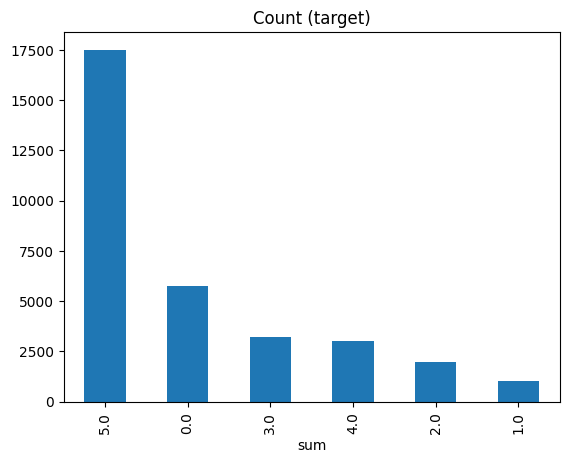

In [29]:
data2.value_counts('sum').plot(kind='bar', title='Count (target)')